In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataset import get_dataloaders
from utils.metrics import evaluate_model  # Ensure it returns: report, accuracy, matrix

from models.vgg import CustomVGG
from models.resnet import CustomResNet
from models.mobilenet import CustomMobileNet
from models.inception import CustomInception
from models.densenet import CustomDenseNet

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [2]:
data_dir = r'Pets\Master Folder'
train_loader, val_loader, class_names = get_dataloaders(data_dir)
num_classes = len(class_names)


In [3]:
model_map = {
    'vgg': CustomVGG,
    'resnet': CustomResNet,
    'mobilenet': CustomMobileNet,
    'inception': CustomInception,
    'densenet': CustomDenseNet
}
model_name = 'resnet'  # Change to: vgg, resnet, mobilenet, inception, densenet
model = model_map[model_name](num_classes=num_classes).to(device)


In [ ]:
def train_and_evaluate_model(model_name, model_class, num_classes, device, 
                             train_loader, val_loader, class_names, epochs=10, lr=1e-3):
    print(f"\n==== Training {model_name.upper()} model ====")
    model = model_class(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"\nEpoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")

        # Evaluation
        report, accuracy, matrix = evaluate_model(model, val_loader, device, class_names)
        val_accuracies.append(accuracy)

        print("\nValidation Classification Report:\n", report)
        print("\nConfusion Matrix:")
        print(matrix)

        # Plot confusion matrix for each epoch
        plot_confusion_matrix(matrix, class_names, f"{model_name} - Epoch {epoch+1}")

        # Save best model
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')
            print(f"New best model saved (Accuracy: {best_acc:.4f})")

        scheduler.step()

    # Plot final training loss and accuracy
    plot_training_curves(train_losses, val_accuracies, model_name)

    # Print final accuracy
    print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}\n")

    del model
    torch.cuda.empty_cache()


def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


def plot_training_curves(train_losses, val_accuracies, model_name):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', color='blue', label='Training Loss')
    plt.title(f"{model_name.upper()} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, marker='x', color='green', label='Validation Accuracy')
    plt.title(f"{model_name.upper()} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


==== Training MOBILENET model ====

Epoch [1/10] - Training Loss: 1.3929

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2414    0.7778    0.3684         9
       Other     0.2500    0.1667    0.2000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.6667    0.1818    0.2857        11

    accuracy                         0.2778        36
   macro avg     0.2895    0.2816    0.2135        36
weighted avg     0.3057    0.2778    0.2127        36


Confusion Matrix:
[[7 1 0 1]
 [5 1 0 0]
 [9 1 0 0]
 [8 1 0 2]]


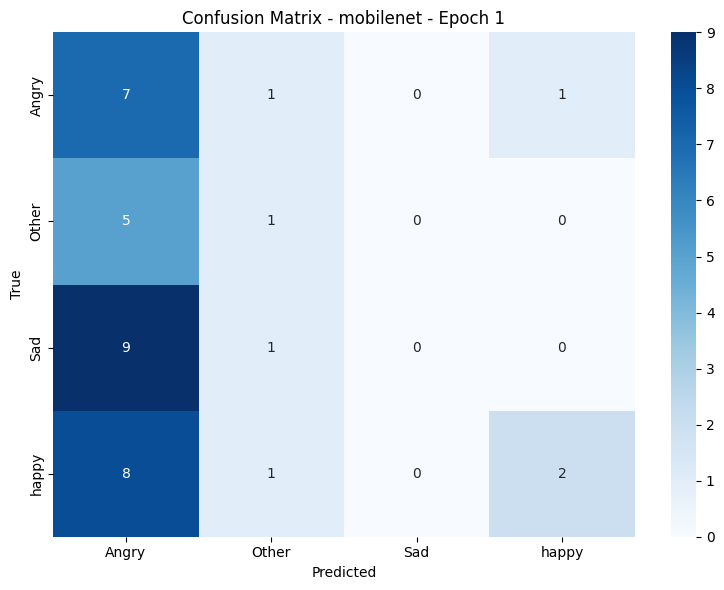

New best model saved (Accuracy: 0.2778)

Epoch [2/10] - Training Loss: 1.3625

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.4000    0.2222    0.2857         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2000    0.4000    0.2667        10
       happy     0.4286    0.2727    0.3333        11

    accuracy                         0.2500        36
   macro avg     0.2571    0.2237    0.2214        36
weighted avg     0.2865    0.2500    0.2474        36


Confusion Matrix:
[[2 0 6 1]
 [1 0 4 1]
 [2 2 4 2]
 [0 2 6 3]]


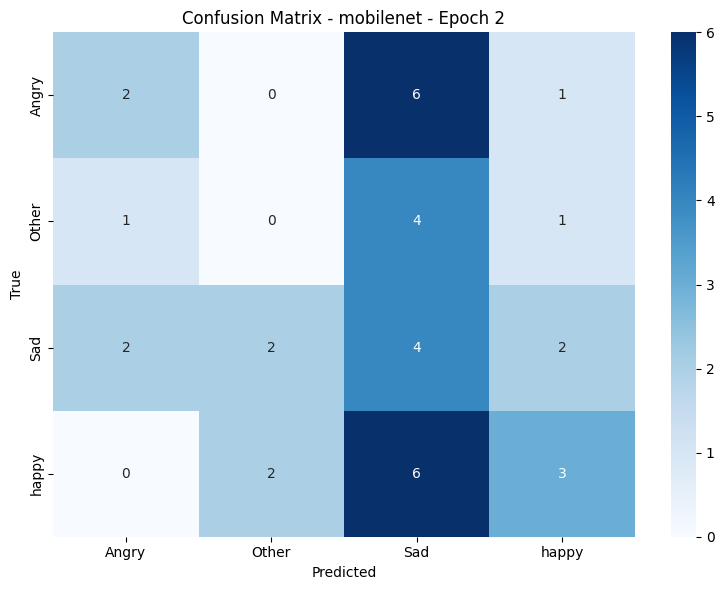


Epoch [3/10] - Training Loss: 1.3342

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3333    0.4444    0.3810         9
       Other     0.1765    0.5000    0.2609         6
         Sad     0.2500    0.1000    0.1429        10
       happy     0.6667    0.1818    0.2857        11

    accuracy                         0.2778        36
   macro avg     0.3566    0.3066    0.2676        36
weighted avg     0.3859    0.2778    0.2657        36


Confusion Matrix:
[[4 2 2 1]
 [2 3 1 0]
 [3 6 1 0]
 [3 6 0 2]]


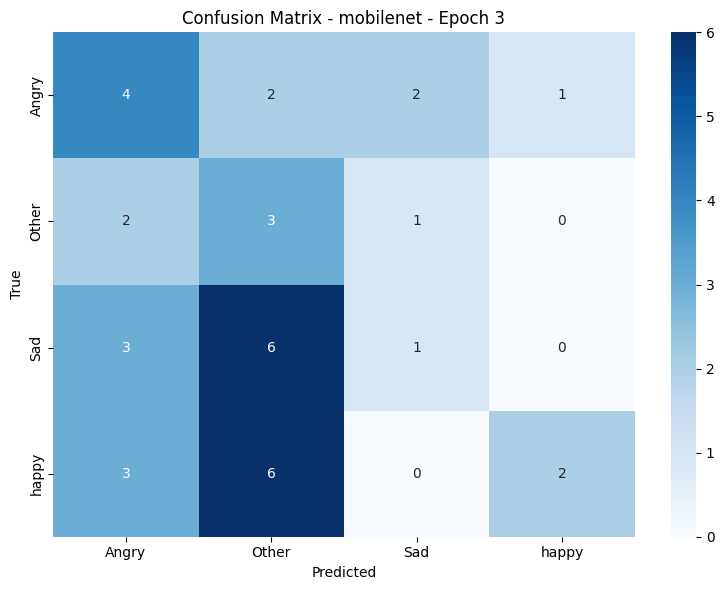


Epoch [4/10] - Training Loss: 1.3155

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1429    0.1111    0.1250         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3333    0.4000    0.3636        10
       happy     0.5294    0.8182    0.6429        11

    accuracy                         0.3889        36
   macro avg     0.2514    0.3323    0.2829        36
weighted avg     0.2901    0.3889    0.3287        36


Confusion Matrix:
[[1 0 4 4]
 [2 0 2 2]
 [4 0 4 2]
 [0 0 2 9]]


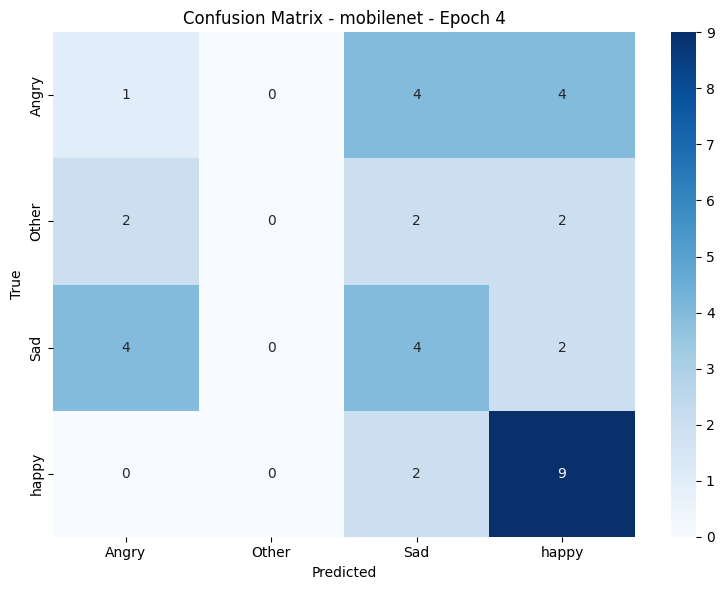

New best model saved (Accuracy: 0.3889)

Epoch [5/10] - Training Loss: 1.2892

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1875    0.3333    0.2400         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2222    0.2000    0.2105        10
       happy     0.6667    0.3636    0.4706        11

    accuracy                         0.2500        36
   macro avg     0.2691    0.2242    0.2303        36
weighted avg     0.3123    0.2500    0.2623        36


Confusion Matrix:
[[3 1 3 2]
 [4 0 2 0]
 [5 3 2 0]
 [4 1 2 4]]


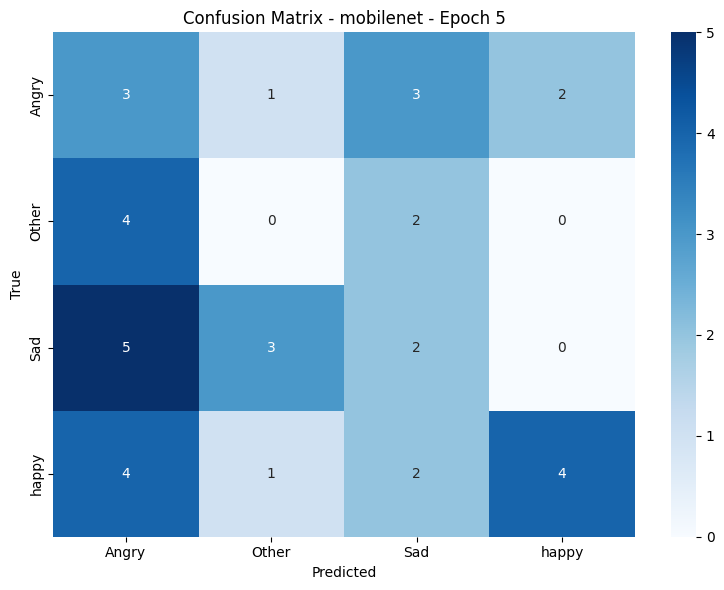


Epoch [6/10] - Training Loss: 1.2400

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2143    0.3333    0.2609         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2500    0.2000    0.2222        10
       happy     0.6667    0.5455    0.6000        11

    accuracy                         0.3056        36
   macro avg     0.2827    0.2697    0.2708        36
weighted avg     0.3267    0.3056    0.3103        36


Confusion Matrix:
[[3 1 3 2]
 [3 0 2 1]
 [5 3 2 0]
 [3 1 1 6]]


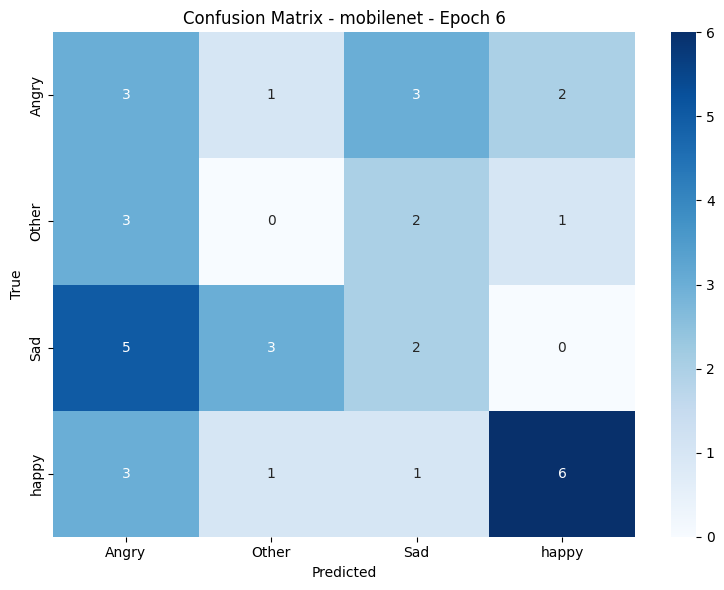


Epoch [7/10] - Training Loss: 1.2252

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.2857    0.3333    0.3077         6
         Sad     0.2222    0.2000    0.2105        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.3333        36
   macro avg     0.3457    0.3303    0.3326        36
weighted avg     0.3628    0.3333    0.3420        36


Confusion Matrix:
[[3 1 3 2]
 [1 2 2 1]
 [5 3 2 0]
 [3 1 2 5]]


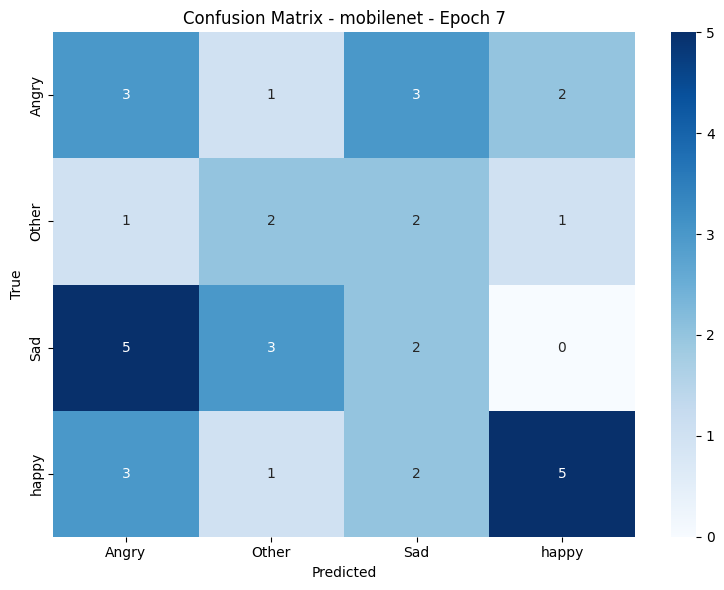


Epoch [8/10] - Training Loss: 1.2145

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2143    0.3333    0.2609         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2222    0.2000    0.2105        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.2778        36
   macro avg     0.2654    0.2470    0.2494        36
weighted avg     0.3063    0.2778    0.2845        36


Confusion Matrix:
[[3 1 3 2]
 [3 0 2 1]
 [5 3 2 0]
 [3 1 2 5]]


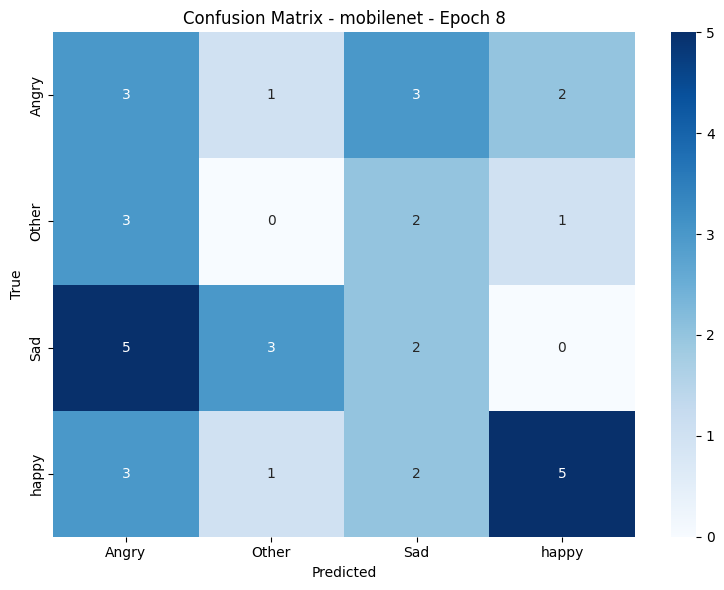


Epoch [9/10] - Training Loss: 1.2007

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3000    0.3000    0.3000        10
       happy     0.5556    0.4545    0.5000        11

    accuracy                         0.3056        36
   macro avg     0.2716    0.2720    0.2682        36
weighted avg     0.3108    0.3056    0.3043        36


Confusion Matrix:
[[3 1 3 2]
 [2 0 2 2]
 [5 2 3 0]
 [3 1 2 5]]


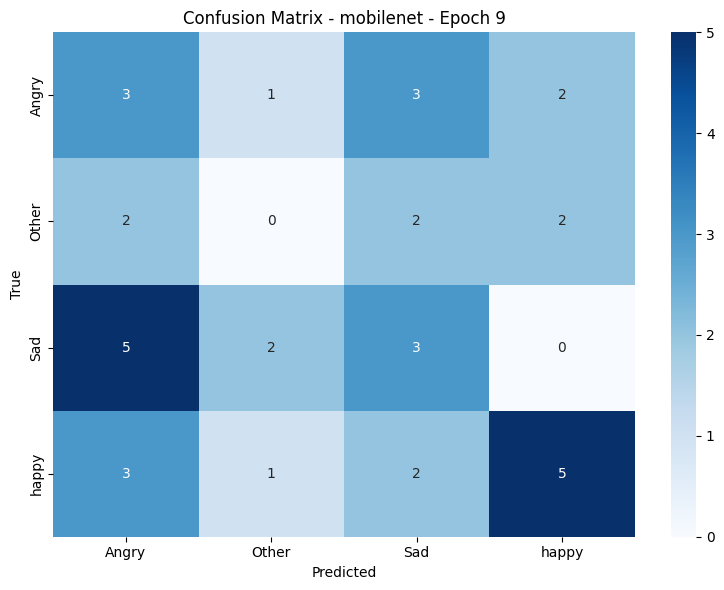


Epoch [10/10] - Training Loss: 1.1977

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2222    0.2000    0.2105        10
       happy     0.5000    0.3636    0.4211        11

    accuracy                         0.2500        36
   macro avg     0.2382    0.2242    0.2261        36
weighted avg     0.2722    0.2500    0.2553        36


Confusion Matrix:
[[3 1 3 2]
 [2 0 2 2]
 [5 3 2 0]
 [3 2 2 4]]


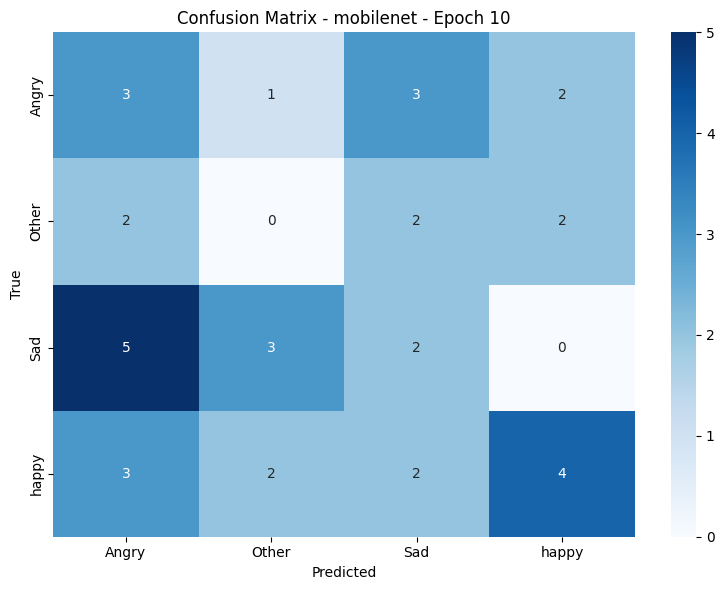

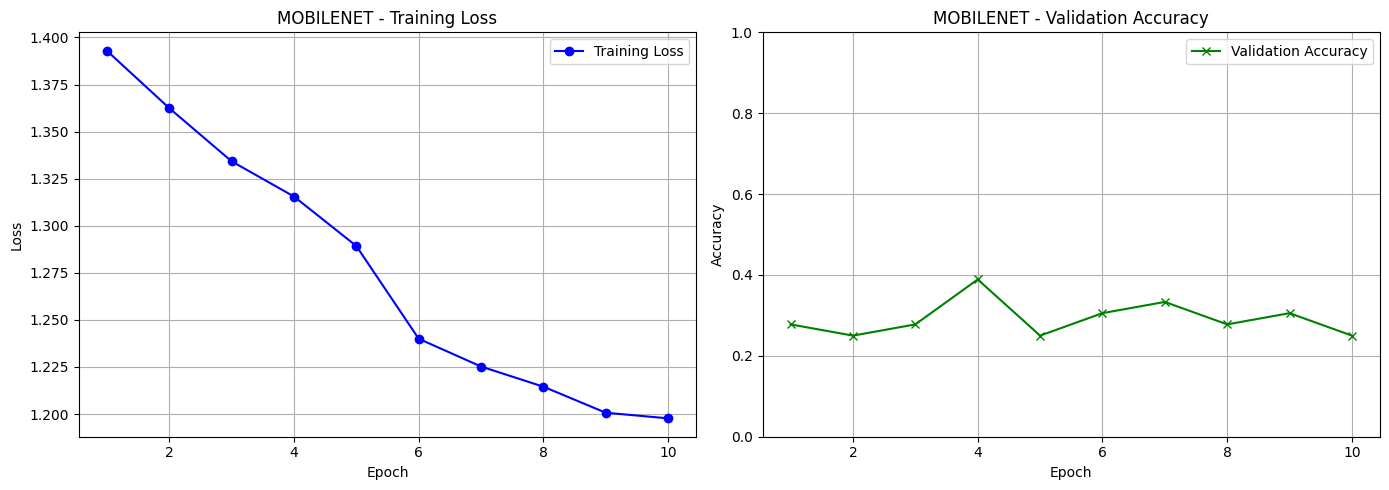


Training complete. Best validation accuracy: 0.3889



In [5]:
model_map = {
    'vgg': CustomVGG,
    'resnet': CustomResNet,
    'mobilenet': CustomMobileNet,
    'inception': CustomInception,
    'densenet': CustomDenseNet
}
model_name = 'mobilenet'  # Change to: vgg, resnet, mobilenet, inception, densenet
model_class = model_map[model_name]
#model = model_map[model_name](num_classes=num_classes).to(device)
train_and_evaluate_model(
        model_name=model_name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )


==== Training RESNET model ====

Epoch [1/10] - Training Loss: 1.5070

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.2222    0.2353         9
       Other     0.2500    0.1667    0.2000         6
         Sad     0.2632    0.5000    0.3448        10
       happy     0.2000    0.0909    0.1250        11

    accuracy                         0.2500        36
   macro avg     0.2408    0.2449    0.2263        36
weighted avg     0.2384    0.2500    0.2261        36


Confusion Matrix:
[[2 2 4 1]
 [1 1 2 2]
 [3 1 5 1]
 [2 0 8 1]]


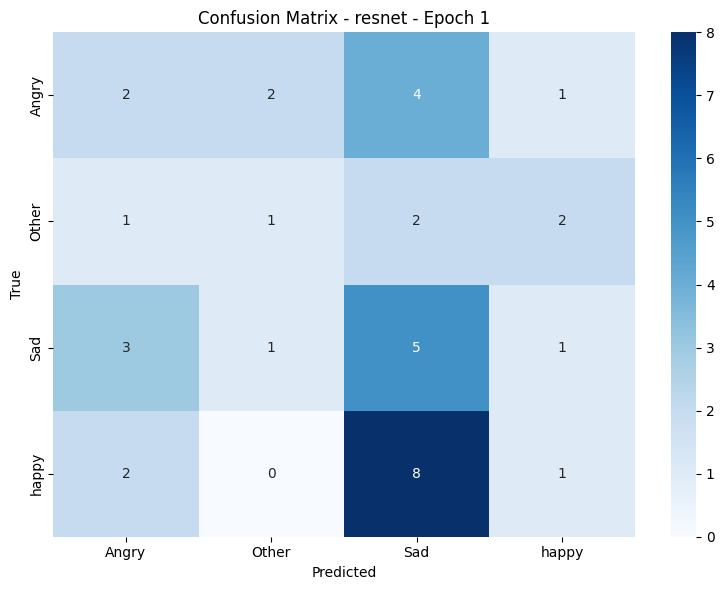

New best model saved (Accuracy: 0.2500)

Epoch [2/10] - Training Loss: 1.4119

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1667    0.3333    0.2222         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.2000    0.2667        10
       happy     0.5714    0.3636    0.4444        11

    accuracy                         0.2500        36
   macro avg     0.2845    0.2242    0.2333        36
weighted avg     0.3274    0.2500    0.2654        36


Confusion Matrix:
[[3 3 1 2]
 [4 0 1 1]
 [6 2 2 0]
 [5 1 1 4]]


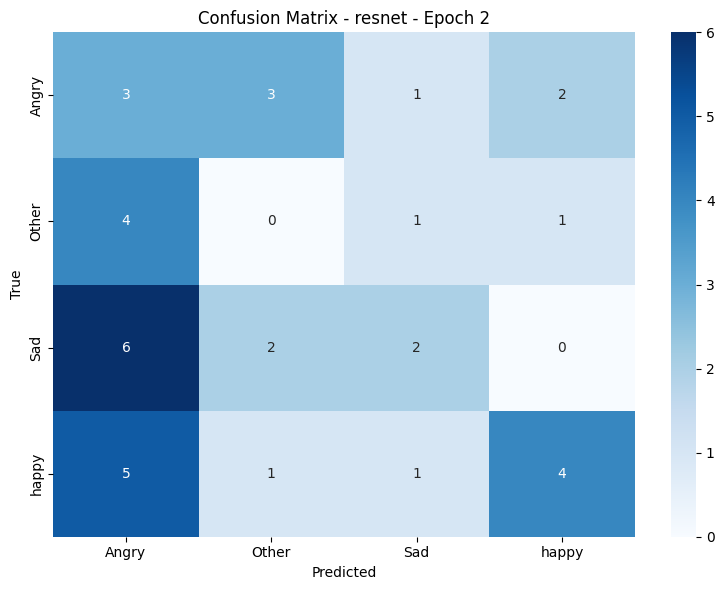


Epoch [3/10] - Training Loss: 1.3487

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3333    0.4444    0.3810         9
       Other     0.2500    0.5000    0.3333         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.5455    0.5217        11

    accuracy                         0.3611        36
   macro avg     0.2708    0.3725    0.3090        36
weighted avg     0.2778    0.3611    0.3102        36


Confusion Matrix:
[[4 3 0 2]
 [2 3 0 1]
 [3 4 0 3]
 [3 2 0 6]]


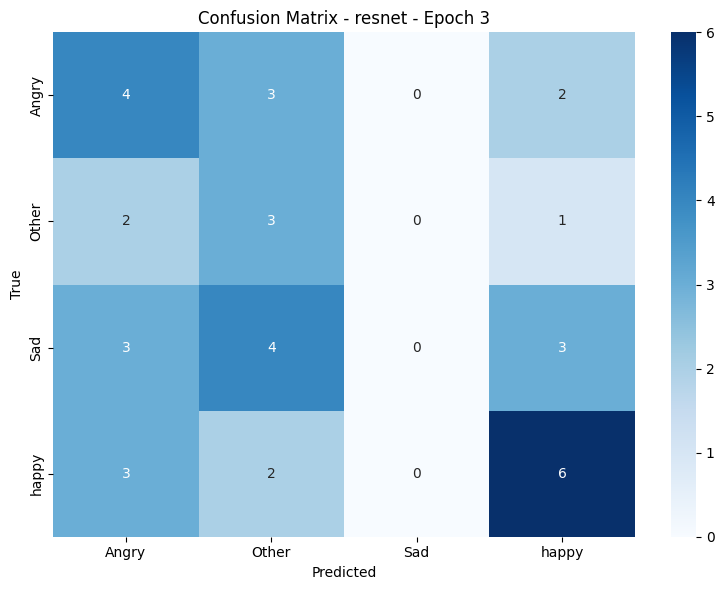

New best model saved (Accuracy: 0.3611)

Epoch [4/10] - Training Loss: 1.3326

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3158    0.6667    0.4286         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.6000    0.5455    0.5714        11

    accuracy                         0.3889        36
   macro avg     0.3004    0.3530    0.3088        36
weighted avg     0.3416    0.3889    0.3471        36


Confusion Matrix:
[[6 0 2 1]
 [4 0 2 0]
 [5 0 2 3]
 [4 0 1 6]]


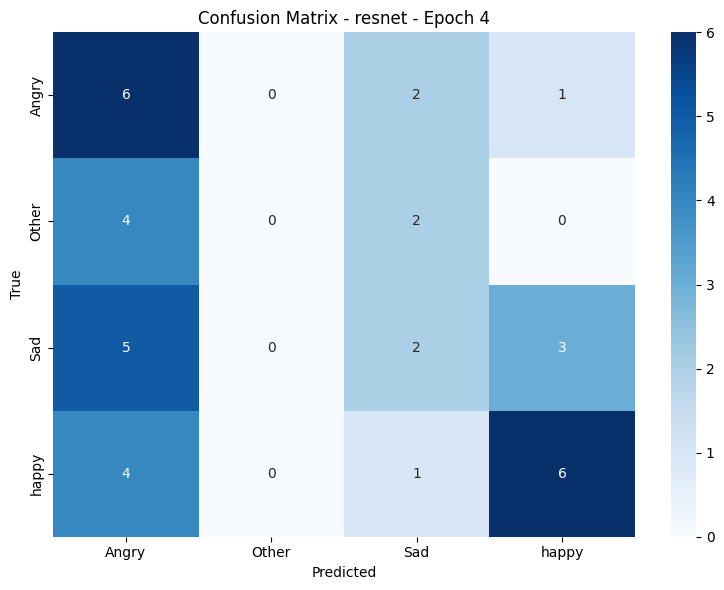

New best model saved (Accuracy: 0.3889)

Epoch [5/10] - Training Loss: 1.3297

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2857    0.4444    0.3478         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.6667    0.7273    0.6957        11

    accuracy                         0.3333        36
   macro avg     0.2381    0.2929    0.2609        36
weighted avg     0.2751    0.3333    0.2995        36


Confusion Matrix:
[[4 0 3 2]
 [2 0 4 0]
 [6 2 0 2]
 [2 0 1 8]]


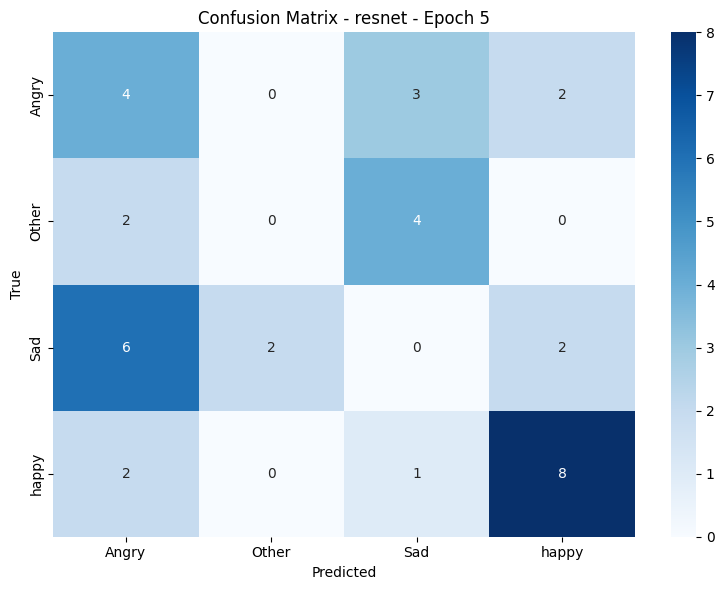


Epoch [6/10] - Training Loss: 1.2867

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.2000    0.1667    0.1818         6
         Sad     0.1000    0.1000    0.1000        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.2778        36
   macro avg     0.2889    0.2636    0.2702        36
weighted avg     0.3098    0.2778    0.2871        36


Confusion Matrix:
[[3 0 5 1]
 [2 1 3 0]
 [4 3 1 2]
 [4 1 1 5]]


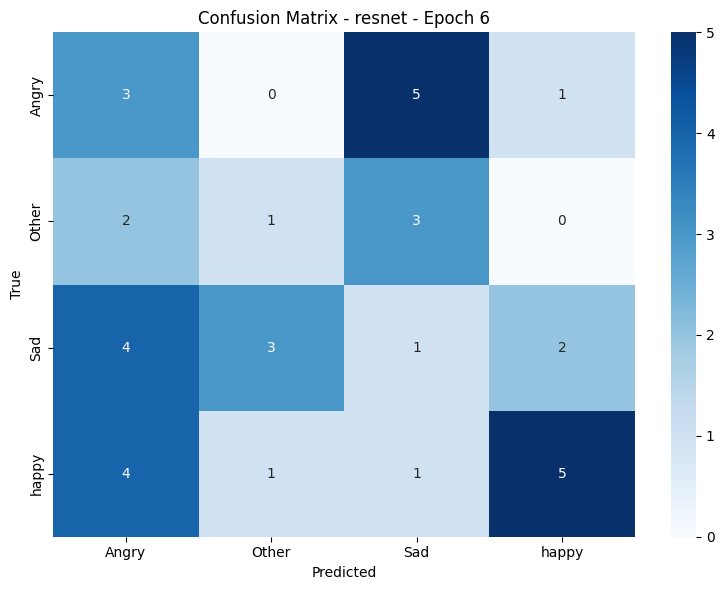


Epoch [7/10] - Training Loss: 1.2437

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1818    0.2222    0.2000         9
       Other     0.1429    0.1667    0.1538         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.6667    0.5455    0.6000        11

    accuracy                         0.2500        36
   macro avg     0.2478    0.2336    0.2385        36
weighted avg     0.2730    0.2500    0.2590        36


Confusion Matrix:
[[2 1 5 1]
 [2 1 3 0]
 [4 4 0 2]
 [3 1 1 6]]


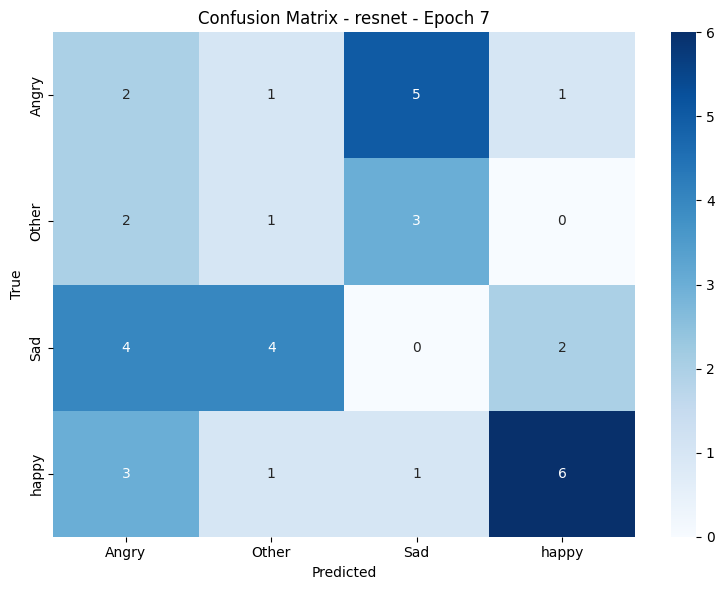


Epoch [8/10] - Training Loss: 1.2189

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2143    0.3333    0.2609         9
       Other     0.2857    0.3333    0.3077         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5556    0.4545    0.5000        11

    accuracy                         0.2778        36
   macro avg     0.2639    0.2803    0.2671        36
weighted avg     0.2709    0.2778    0.2693        36


Confusion Matrix:
[[3 2 3 1]
 [1 2 2 1]
 [5 3 0 2]
 [5 0 1 5]]


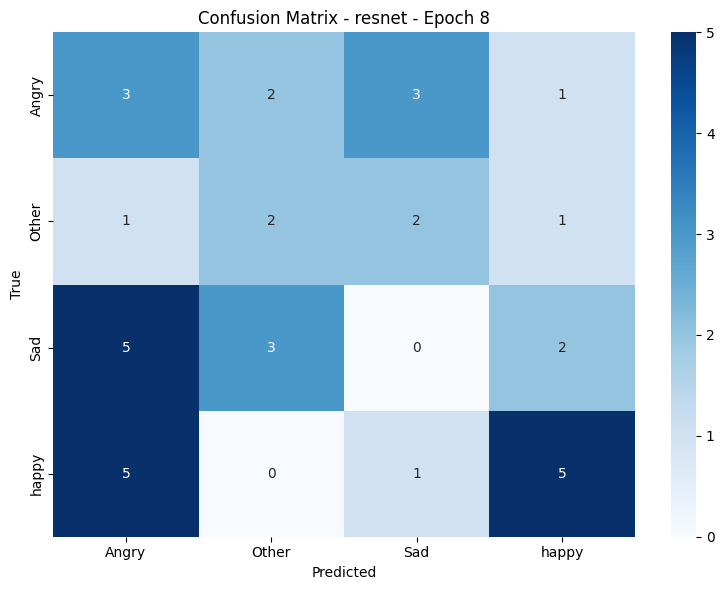


Epoch [9/10] - Training Loss: 1.2129

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2308    0.3333    0.2727         9
       Other     0.2000    0.1667    0.1818         6
         Sad     0.1250    0.1000    0.1111        10
       happy     0.5000    0.4545    0.4762        11

    accuracy                         0.2778        36
   macro avg     0.2639    0.2636    0.2605        36
weighted avg     0.2785    0.2778    0.2749        36


Confusion Matrix:
[[3 1 3 2]
 [1 1 3 1]
 [5 2 1 2]
 [4 1 1 5]]


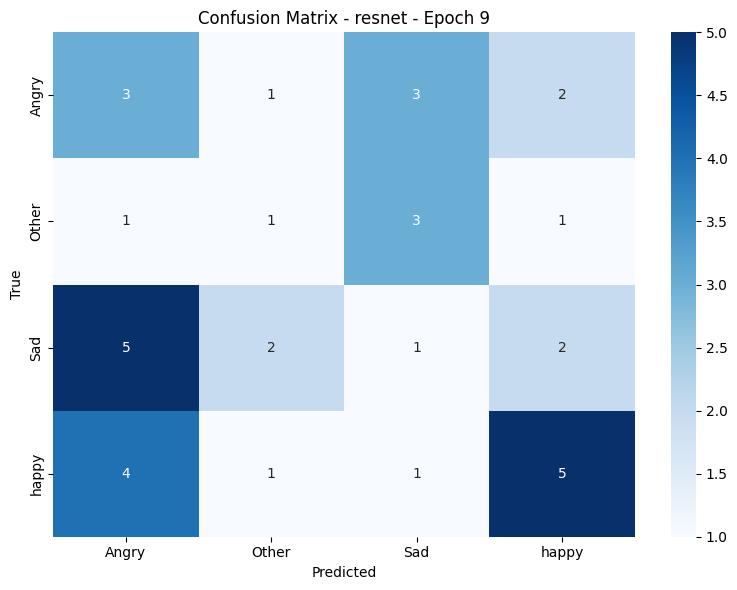


Epoch [10/10] - Training Loss: 1.2009

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1667    0.2222    0.1905         9
       Other     0.1111    0.1667    0.1333         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.3333    0.2727    0.3000        11

    accuracy                         0.1667        36
   macro avg     0.1528    0.1654    0.1560        36
weighted avg     0.1620    0.1667    0.1615        36


Confusion Matrix:
[[2 4 1 2]
 [1 1 2 2]
 [6 2 0 2]
 [3 2 3 3]]


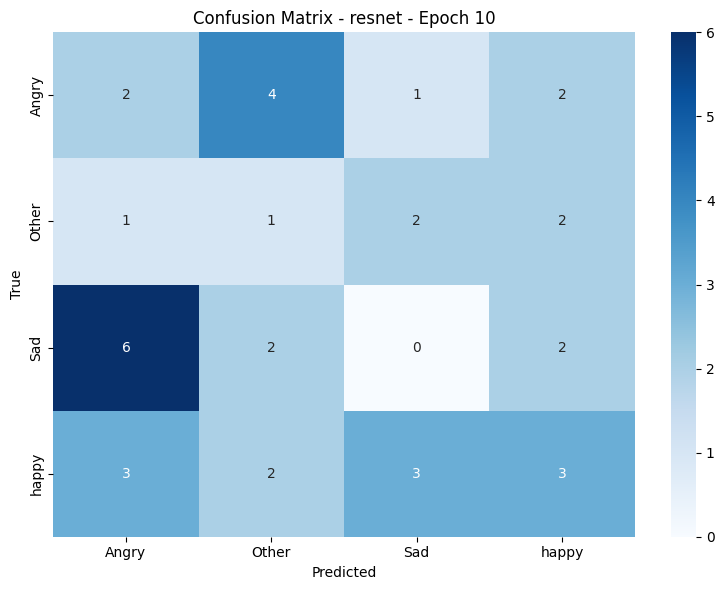

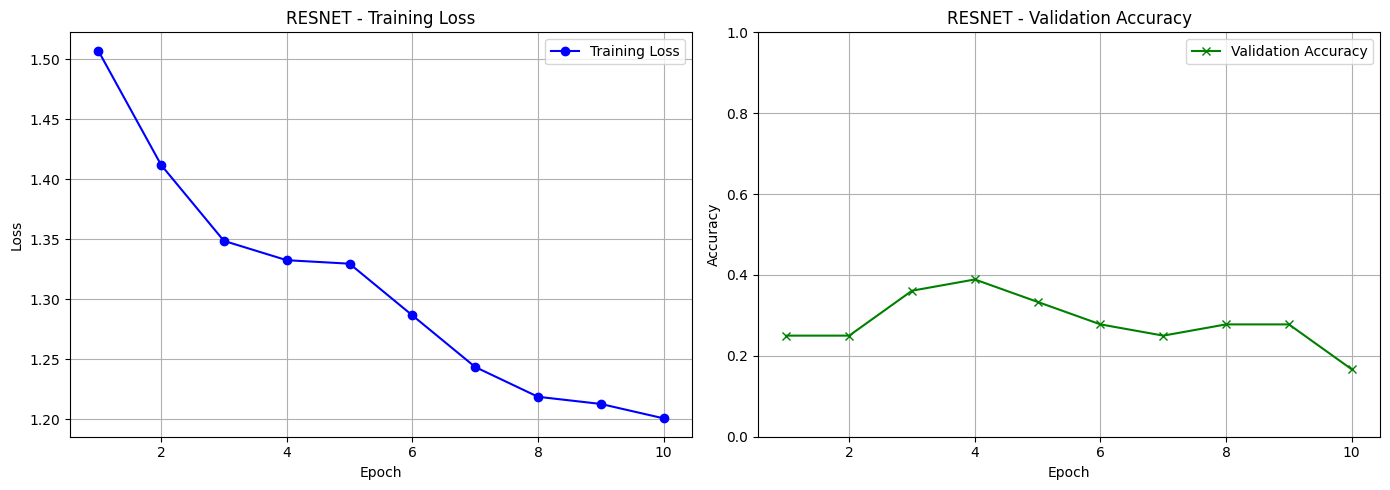


Training complete. Best validation accuracy: 0.3889



In [6]:
model_name = 'resnet'  # Change to: vgg, resnet, mobilenet, inception, densenet
model_class = model_map[model_name]
#model = model_map[model_name](num_classes=num_classes).to(device)
train_and_evaluate_model(
        model_name=model_name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )


==== Training DENSENET model ====

Epoch [1/10] - Training Loss: 1.4131

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2727    0.6667    0.3871         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.5000    0.4545    0.4762        11

    accuracy                         0.3056        36
   macro avg     0.1932    0.2803    0.2158        36
weighted avg     0.2210    0.3056    0.2423        36


Confusion Matrix:
[[6 0 0 3]
 [5 0 0 1]
 [5 4 0 1]
 [6 0 0 5]]


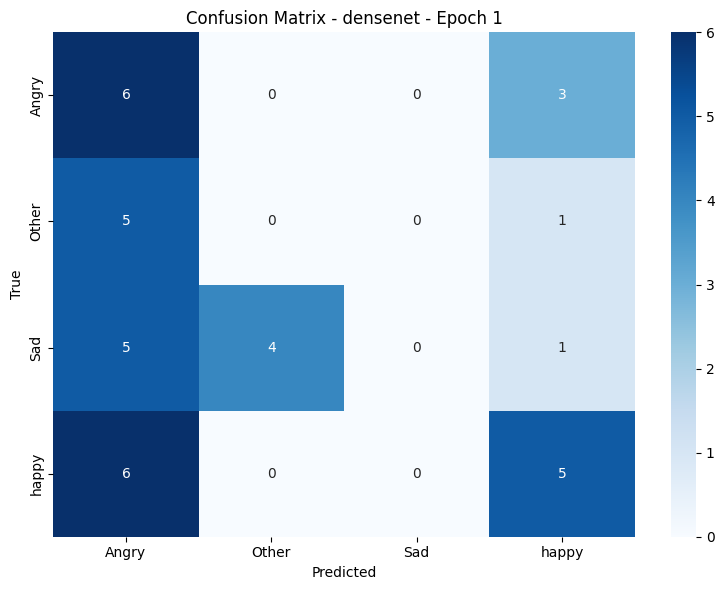

New best model saved (Accuracy: 0.3056)

Epoch [2/10] - Training Loss: 1.3838

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.2308    0.5000    0.3158         6
         Sad     0.3846    0.5000    0.4348        10
       happy     0.4000    0.3636    0.3810        11

    accuracy                         0.3333        36
   macro avg     0.2538    0.3409    0.2829        36
weighted avg     0.2675    0.3333    0.2898        36


Confusion Matrix:
[[0 0 5 4]
 [0 3 2 1]
 [0 4 5 1]
 [0 6 1 4]]


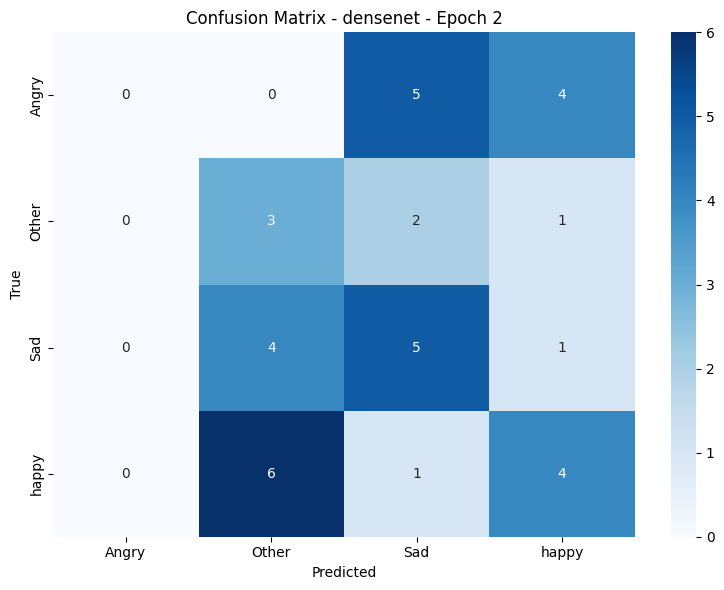

New best model saved (Accuracy: 0.3333)

Epoch [3/10] - Training Loss: 1.3915

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.3333    0.2857         9
       Other     0.1875    0.5000    0.2727         6
         Sad     0.2500    0.1000    0.1429        10
       happy     0.7500    0.2727    0.4000        11

    accuracy                         0.2778        36
   macro avg     0.3594    0.3015    0.2753        36
weighted avg     0.3924    0.2778    0.2788        36


Confusion Matrix:
[[3 4 1 1]
 [2 3 1 0]
 [5 4 1 0]
 [2 5 1 3]]


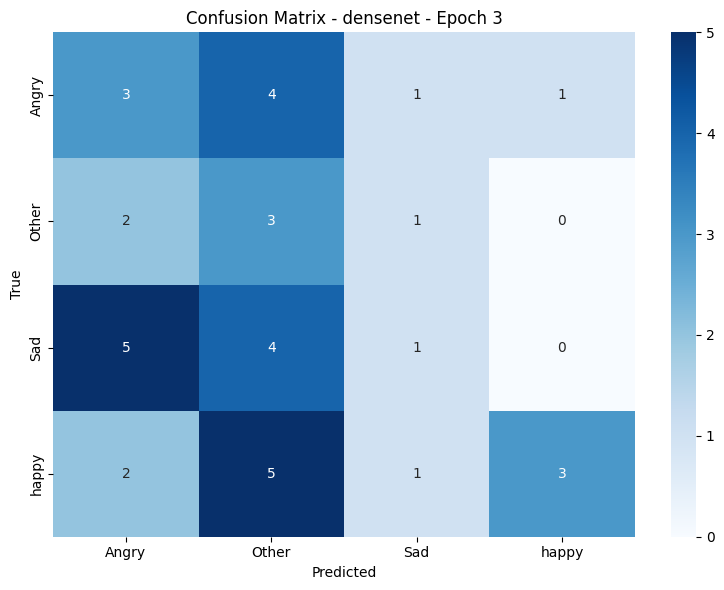


Epoch [4/10] - Training Loss: 1.3778

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2941    0.5556    0.3846         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.0000    0.0000    0.0000        10
       happy     0.4667    0.6364    0.5385        11

    accuracy                         0.3333        36
   macro avg     0.1902    0.2980    0.2308        36
weighted avg     0.2161    0.3333    0.2607        36


Confusion Matrix:
[[5 0 1 3]
 [4 0 1 1]
 [5 1 0 4]
 [3 0 1 7]]


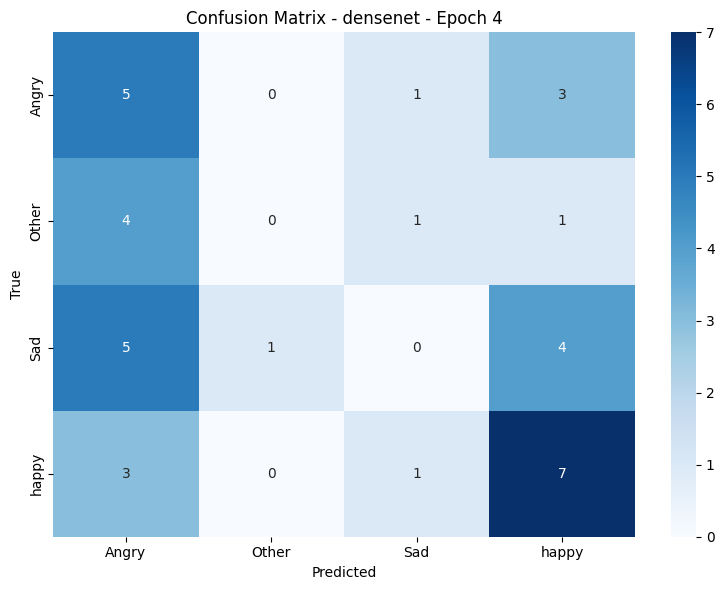


Epoch [5/10] - Training Loss: 1.3823

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2609    0.6667    0.3750         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2000    0.1000    0.1333        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.3333        36
   macro avg     0.2715    0.3053    0.2587        36
weighted avg     0.3117    0.3333    0.2916        36


Confusion Matrix:
[[6 0 1 2]
 [4 0 2 0]
 [8 0 1 1]
 [5 0 1 5]]


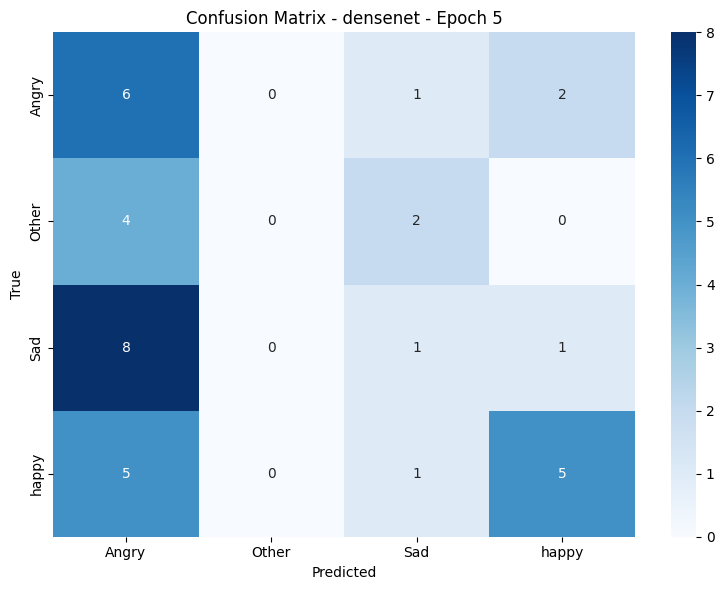


Epoch [6/10] - Training Loss: 1.3675

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2778    0.5556    0.3704         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.5556    0.4545    0.5000        11

    accuracy                         0.3333        36
   macro avg     0.2798    0.3025    0.2764        36
weighted avg     0.3186    0.3333    0.3107        36


Confusion Matrix:
[[5 0 2 2]
 [3 0 2 1]
 [6 1 2 1]
 [4 1 1 5]]


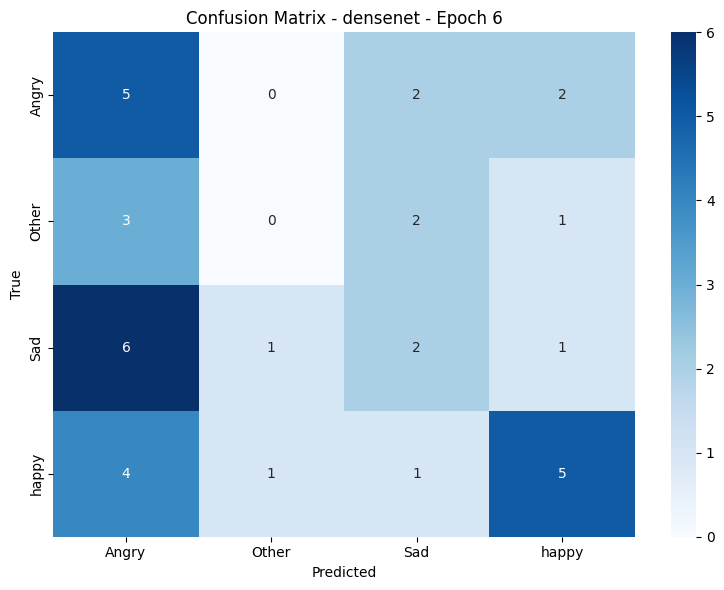


Epoch [7/10] - Training Loss: 1.3642

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2667    0.4444    0.3333         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3000    0.3000    0.3000        10
       happy     0.5000    0.3636    0.4211        11

    accuracy                         0.3056        36
   macro avg     0.2667    0.2770    0.2636        36
weighted avg     0.3028    0.3056    0.2953        36


Confusion Matrix:
[[4 1 2 2]
 [3 0 2 1]
 [5 1 3 1]
 [3 1 3 4]]


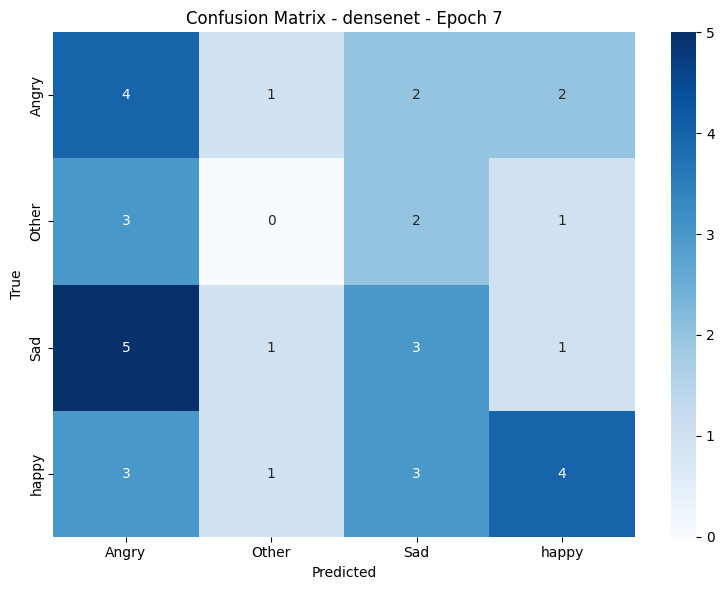


Epoch [8/10] - Training Loss: 1.3552

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2667    0.4444    0.3333         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.5556    0.4545    0.5000        11

    accuracy                         0.3056        36
   macro avg     0.2770    0.2747    0.2672        36
weighted avg     0.3158    0.3056    0.3015        36


Confusion Matrix:
[[4 1 2 2]
 [3 0 2 1]
 [5 2 2 1]
 [3 2 1 5]]


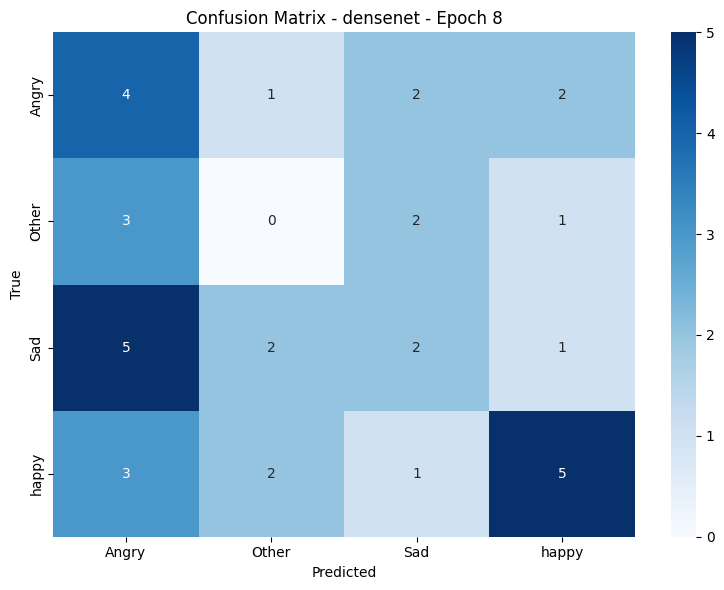


Epoch [9/10] - Training Loss: 1.3570

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2667    0.4444    0.3333         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.3056        36
   macro avg     0.2943    0.2747    0.2737        36
weighted avg     0.3370    0.3056    0.3095        36


Confusion Matrix:
[[4 1 2 2]
 [3 0 2 1]
 [5 3 2 0]
 [3 2 1 5]]


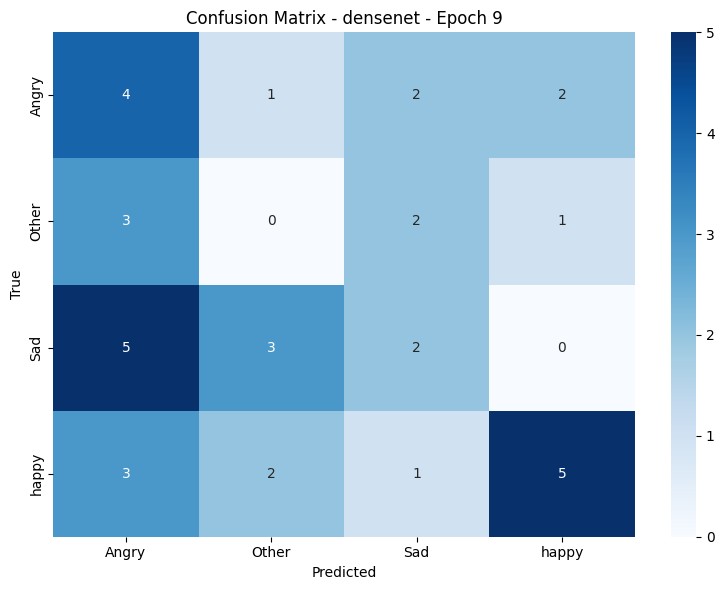


Epoch [10/10] - Training Loss: 1.3538

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.4444    0.3200         9
       Other     0.1250    0.1667    0.1429         6
         Sad     0.2857    0.2000    0.2353        10
       happy     0.6000    0.2727    0.3750        11

    accuracy                         0.2778        36
   macro avg     0.3152    0.2710    0.2683        36
weighted avg     0.3460    0.2778    0.2838        36


Confusion Matrix:
[[4 1 2 2]
 [3 1 2 0]
 [5 3 2 0]
 [4 3 1 3]]


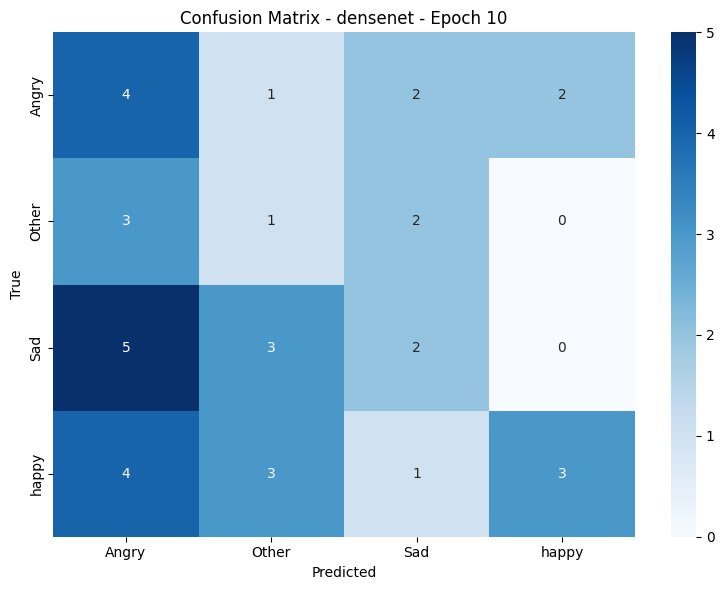

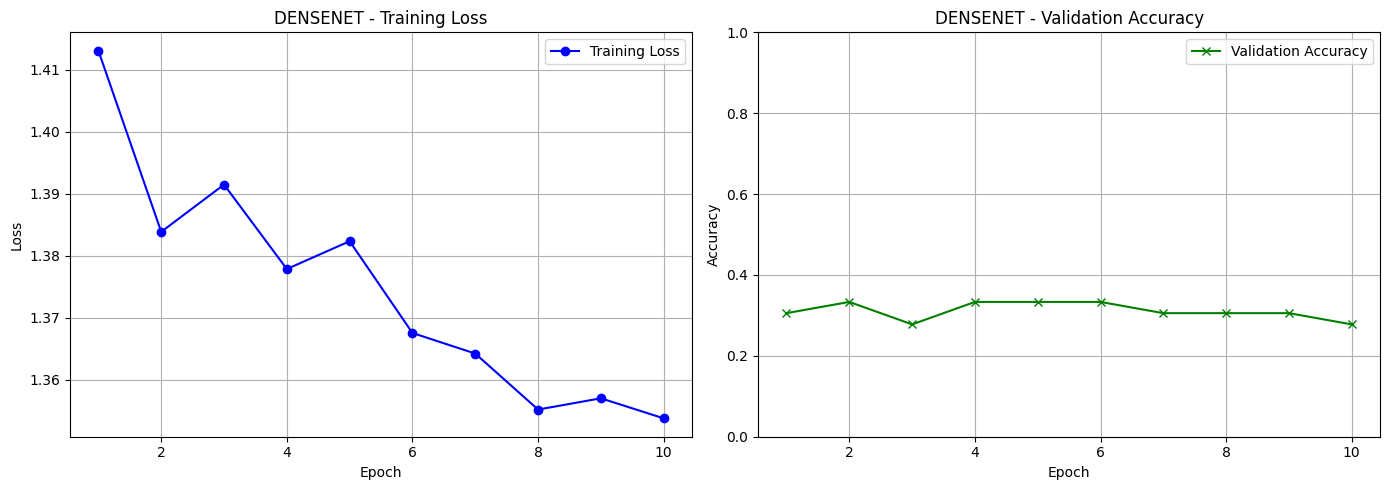


Training complete. Best validation accuracy: 0.3333



In [7]:
model_name = 'densenet'  # Change to: vgg, resnet, mobilenet, inception, densenet
model_class = model_map[model_name]
#model = model_map[model_name](num_classes=num_classes).to(device)
train_and_evaluate_model(
        model_name=model_name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )


==== Training INCEPTION model ====

Epoch [1/10] - Training Loss: 1.3965

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3000    0.3333    0.3158         9
       Other     0.2083    0.8333    0.3333         6
         Sad     1.0000    0.1000    0.1818        10
       happy     0.0000    0.0000    0.0000        11

    accuracy                         0.2500        36
   macro avg     0.3771    0.3167    0.2077        36
weighted avg     0.3875    0.2500    0.1850        36


Confusion Matrix:
[[3 5 0 1]
 [1 5 0 0]
 [1 8 1 0]
 [5 6 0 0]]


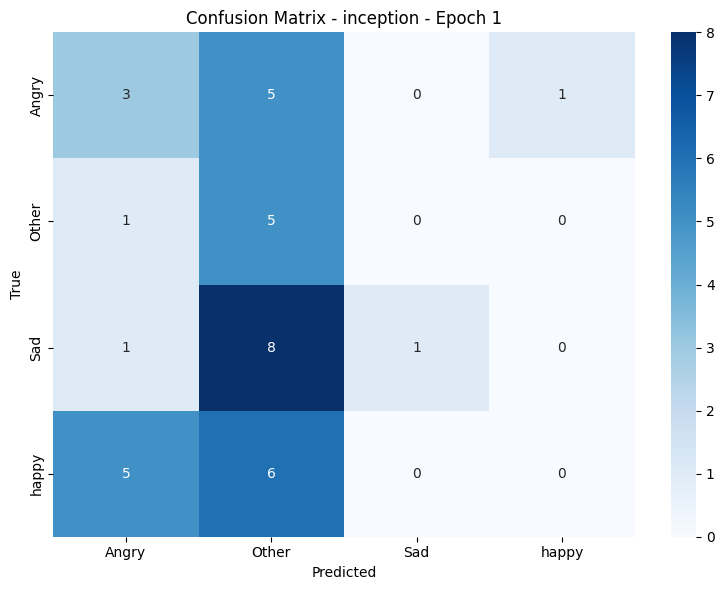

New best model saved (Accuracy: 0.2500)

Epoch [2/10] - Training Loss: 1.3913

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3214    0.9000    0.4737        10
       happy     0.3750    0.2727    0.3158        11

    accuracy                         0.3333        36
   macro avg     0.1741    0.2932    0.1974        36
weighted avg     0.2039    0.3333    0.2281        36


Confusion Matrix:
[[0 0 6 3]
 [0 0 5 1]
 [0 0 9 1]
 [0 0 8 3]]


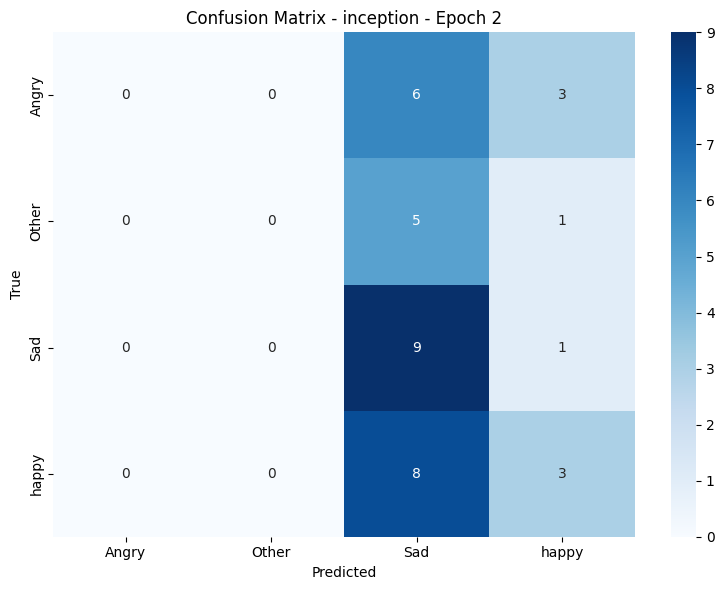

New best model saved (Accuracy: 0.3333)

Epoch [3/10] - Training Loss: 1.3908

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1667    0.1111    0.1333         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3000    0.6000    0.4000        10
       happy     0.3333    0.2727    0.3000        11

    accuracy                         0.2778        36
   macro avg     0.2000    0.2460    0.2083        36
weighted avg     0.2269    0.2778    0.2361        36


Confusion Matrix:
[[1 0 5 3]
 [0 0 4 2]
 [2 1 6 1]
 [3 0 5 3]]


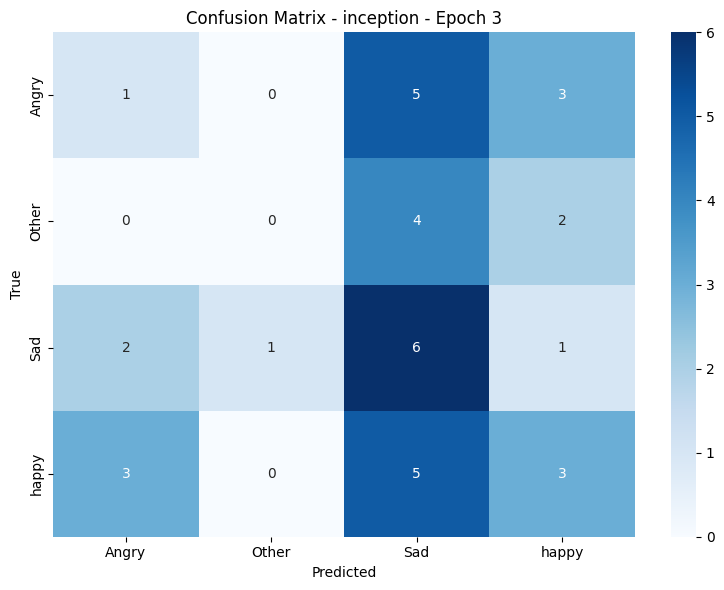


Epoch [4/10] - Training Loss: 1.3845

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2778    0.5556    0.3704         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3333    0.1000    0.1538        10
       happy     0.4000    0.5455    0.4615        11

    accuracy                         0.3333        36
   macro avg     0.2528    0.3003    0.2464        36
weighted avg     0.2843    0.3333    0.2764        36


Confusion Matrix:
[[5 0 1 3]
 [4 0 0 2]
 [5 0 1 4]
 [4 0 1 6]]


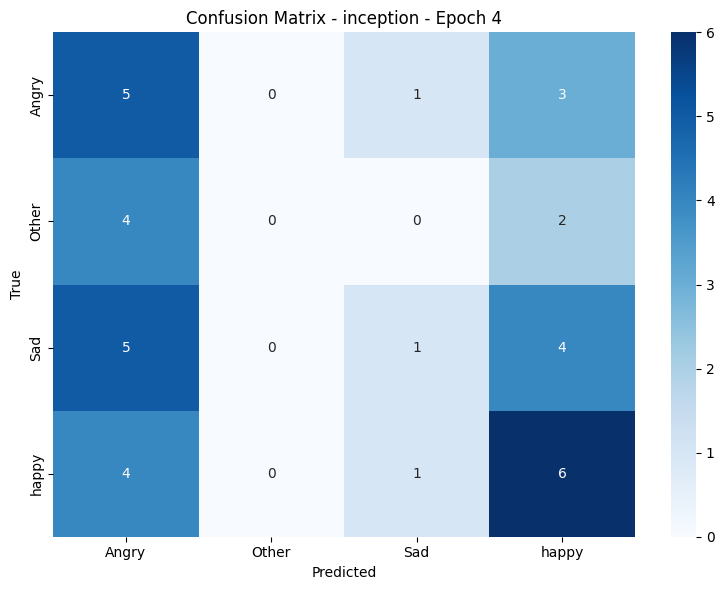


Epoch [5/10] - Training Loss: 1.3855

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.3000    0.3333    0.3158         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.4000    0.4000        10
       happy     0.3636    0.3636    0.3636        11

    accuracy                         0.3056        36
   macro avg     0.2659    0.2742    0.2699        36
weighted avg     0.2972    0.3056    0.3012        36


Confusion Matrix:
[[3 0 3 3]
 [3 0 1 2]
 [2 2 4 2]
 [2 3 2 4]]


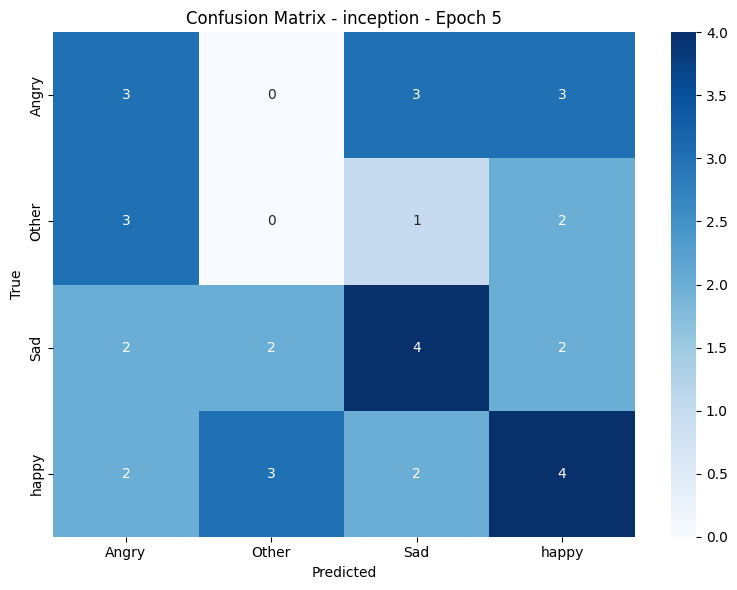


Epoch [6/10] - Training Loss: 1.3765

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.2222    0.2353         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.3636    0.4000    0.3810        10
       happy     0.3636    0.3636    0.3636        11

    accuracy                         0.2778        36
   macro avg     0.2443    0.2465    0.2450        36
weighted avg     0.2746    0.2778    0.2758        36


Confusion Matrix:
[[2 1 3 3]
 [2 0 2 2]
 [2 2 4 2]
 [2 3 2 4]]


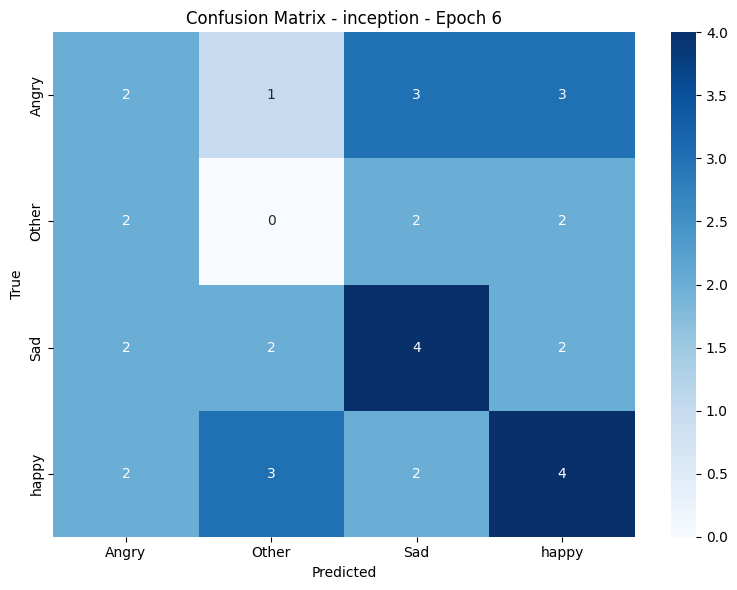


Epoch [7/10] - Training Loss: 1.3758

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.2222    0.2353         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.4000    0.4000        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.3056        36
   macro avg     0.2667    0.2692    0.2675        36
weighted avg     0.3009    0.3056    0.3028        36


Confusion Matrix:
[[2 1 3 3]
 [2 0 2 2]
 [2 2 4 2]
 [2 3 1 5]]


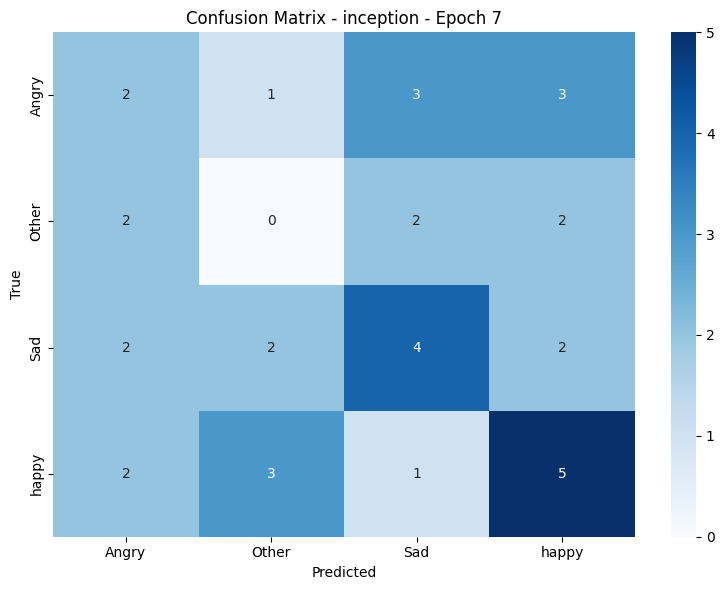


Epoch [8/10] - Training Loss: 1.3753

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1429    0.1111    0.1250         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.4000    0.4000        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.2778        36
   macro avg     0.2399    0.2414    0.2399        36
weighted avg     0.2741    0.2778    0.2752        36


Confusion Matrix:
[[1 2 3 3]
 [2 0 2 2]
 [2 2 4 2]
 [2 3 1 5]]


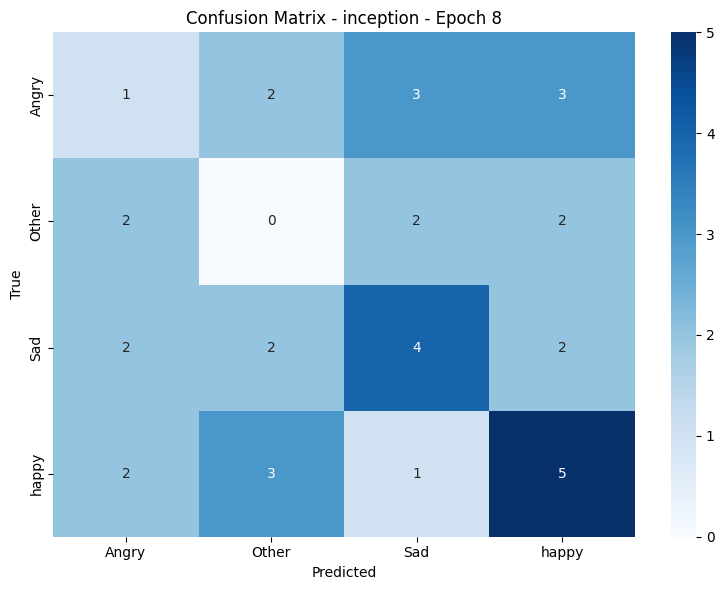


Epoch [9/10] - Training Loss: 1.3757

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.1429    0.1111    0.1250         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.4000    0.4000        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.2778        36
   macro avg     0.2399    0.2414    0.2399        36
weighted avg     0.2741    0.2778    0.2752        36


Confusion Matrix:
[[1 2 3 3]
 [2 0 2 2]
 [2 2 4 2]
 [2 3 1 5]]


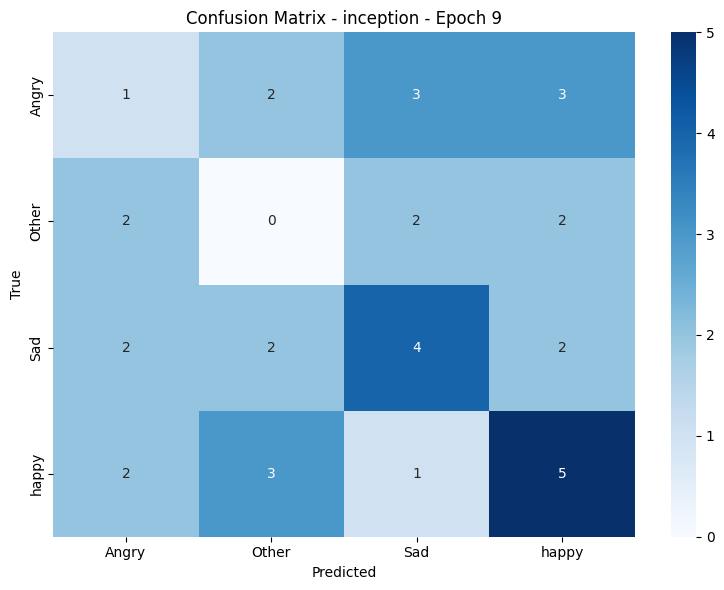


Epoch [10/10] - Training Loss: 1.3749

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2500    0.2222    0.2353         9
       Other     0.0000    0.0000    0.0000         6
         Sad     0.4000    0.4000    0.4000        10
       happy     0.4167    0.4545    0.4348        11

    accuracy                         0.3056        36
   macro avg     0.2667    0.2692    0.2675        36
weighted avg     0.3009    0.3056    0.3028        36


Confusion Matrix:
[[2 1 3 3]
 [2 0 2 2]
 [2 2 4 2]
 [2 3 1 5]]


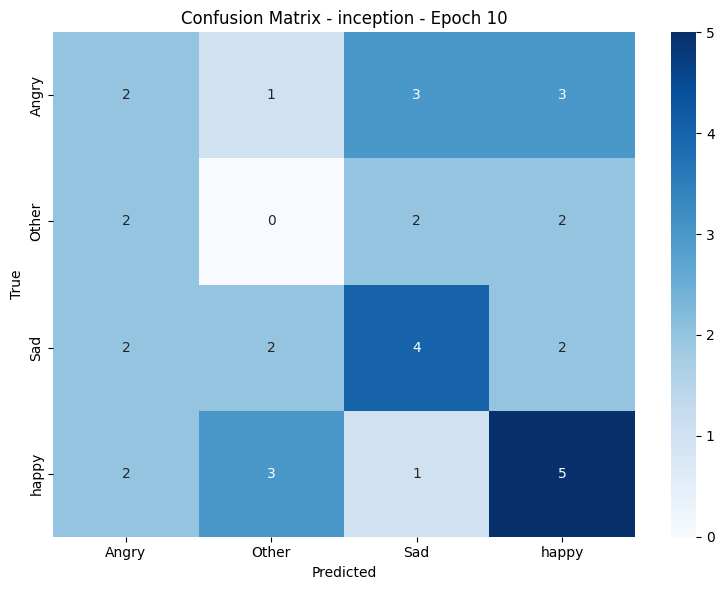

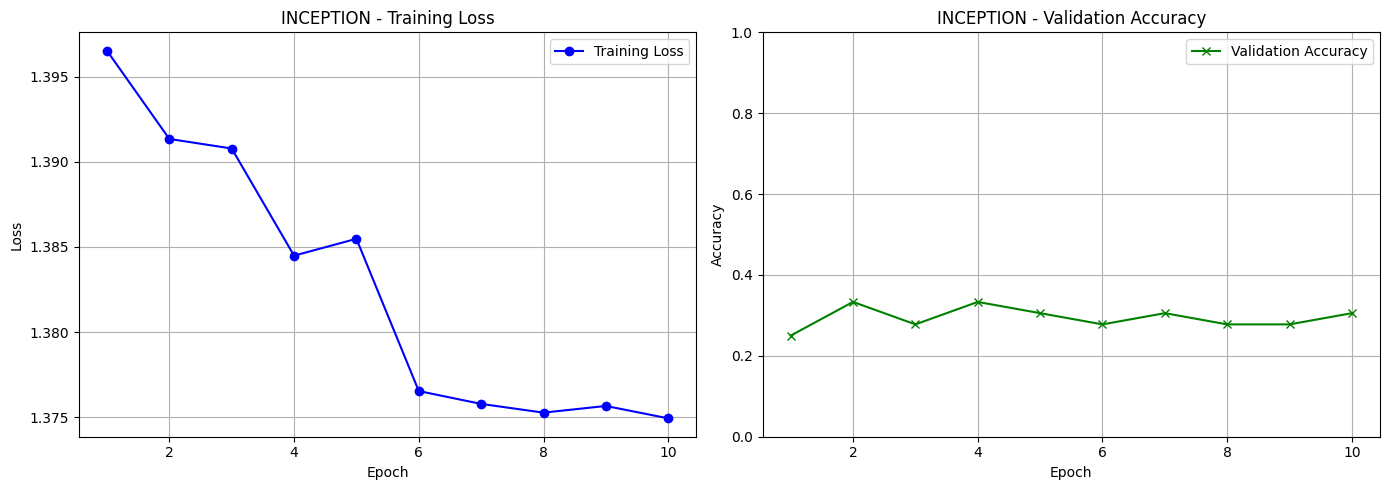


Training complete. Best validation accuracy: 0.3333



In [8]:
model_map = {
    'vgg': CustomVGG,
    'resnet': CustomResNet,
    'mobilenet': CustomMobileNet,
    'inception': CustomInception,
    'densenet': CustomDenseNet
}
model_name = 'inception'  # Change to: vgg, resnet, mobilenet, inception, densenet
model_class = model_map[model_name]
#model = model_map[model_name](num_classes=num_classes).to(device)
train_and_evaluate_model(
        model_name=model_name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )

In [21]:
model_name = 'vgg'  # Change to: vgg, resnet, mobilenet, inception, densenet
model_class = model_map[model_name]
#model = model_map[model_name](num_classes=num_classes).to(device)
train_and_evaluate_model(
        model_name=model_name,
        model_class=model_class,
        num_classes=num_classes,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        epochs=10,
        lr=1e-3
    )


==== Training VGG model ====


AttributeError: 'Tensor' object has no attribute 'convert'